In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook
import plotly.offline as pyo
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from datetime import date

In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
%matplotlib inline
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False) 

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# go to file
os.chdir('../DATA_raw2')

# 유지기간 반영해서 order 정리




In [ ]:
user = pd.read_pickle("../TBWA/user_fin.pkl")
order = pd.read_pickle("../TBWA/order_fin.pkl")

In [ ]:
user['최초가입일2'] = user['최초가입일'].astype(str)
user['최초가입연월'] = user['최초가입일2'].str[:7]

user['최종가입일2'] = user['최종가입일'].astype(str)
user['최종가입연월'] = user['최종가입일2'].str[:7]

user['최초가입연도'] = user['최초가입일'].dt.year
user['최종가입연도'] = user['최종가입일'].dt.year
user['최초가입월'] = user['최초가입일'].dt.month
user['최종가입월'] = user['최종가입일'].dt.month

In [ ]:
dateformat = "%Y-%m-%d"
str_datetime = "2022-12-31"
datetime_convert = datetime.strptime(str_datetime, dateformat)
datetime_convert

datetime.datetime(2022, 12, 31, 0, 0)

In [ ]:
user = user[user.최종가입일 <= datetime_convert].reset_index(drop = True)

In [ ]:
dateformat = "%Y-%m-%d"
str_datetime = "2023-01-01"
datetime_convert2 = datetime.strptime(str_datetime, dateformat)
datetime_convert2

datetime.datetime(2023, 1, 1, 0, 0)

In [ ]:
user['유지기간'] = datetime_convert2 - user.최종가입일
user.유지기간 = user.유지기간.dt.days
user.유지기간 = user.유지기간 / 30 / 12 # 개월 단위

In [ ]:
user.유지기간.mean()

1.2369165150914114

In [ ]:
order['구매일자2'] = order['구매일자'].astype(str)
order['구매연월'] = order['구매일자2'].str[:7]
order['구매연도'] = order['구매일자'].dt.year
order['구매월'] = order['구매일자'].dt.month

In [ ]:
df = pd.merge(order, user[['고유번호', '최초가입일', '최종가입일', '최종탈퇴일', '재가입횟수']], on = '고유번호', how = 'left')

In [ ]:
len(df[df.구매일자 < df.최초가입일])

20681

In [ ]:
# 재가입자들의 이전 데이터 삭제
order2 = df[df.구매일자 >= df.최종가입일].reset_index(drop = True)
order2 = order2[order2.카테고리1 == '신발'].reset_index(drop = True)

In [ ]:
len(user)

1878788

In [ ]:
print(len(order)) 
print(len(order2))
print(len(order)  - len(order2), '건 삭제') 

4928381
3842695
1085686 건 삭제


In [ ]:
## 신발 구매 주기
## 구매주기
data = order2.groupby(['고유번호', '구매일자']).agg({'구매시간':'nunique'})
data = data.reset_index().rename(columns={"index": "id"})
data['직전구매일자'] = data.groupby('고유번호').구매일자.shift()
data['구매소요시간'] = data['구매일자'] - data['직전구매일자']
data['구매소요시간'] = data['구매소요시간'].dt.days
data['구매소요시간'] = np.where(data['구매소요시간'].isna(), 0, data['구매소요시간'])
data2 = data.groupby('고유번호').agg({'구매소요시간':'sum'})
data2 = data2.reset_index().rename(columns={"index": "id"})
data3 = data.groupby('고유번호').agg({'구매시간':'sum'})   #같은날에 많이 사는건 주기에 안치면 구매소요시간:count, 치면 '상품명':sum 으로
data3 = data3.reset_index().rename(columns={"index": "id"})
data3.columns = ['고유번호', '방문횟수']
data3['방문횟수'] = data3['방문횟수'] -1
df = pd.merge(data2, data3, on = '고유번호', how = 'inner')
df_0 = df[(df['방문횟수'] == 0) | (df['구매소요시간'] ==0 )]

In [ ]:
df3 = df[~df.고유번호.isin(df_0.고유번호.unique())]
df3['구매주기'] = df3['구매소요시간'] / df3['방문횟수']

In [ ]:
df3['구매주기'].describe() #평균 168일마다 구매

count   537349.0000
mean       168.9425
std        150.1203
min          1.0000
25%         68.2727
50%        135.0000
75%        227.0000
max       1447.0000
Name: 구매주기, dtype: float64

In [ ]:
### 상품당 평균 구매 금액
zz = order2[order2.카테고리1 == '신발']
qq = zz.groupby('고유번호').agg({'구매일자':'count'})
qq = qq.reset_index().rename(columns={"index": "id"})
ww = zz.groupby('고유번호').agg({'결제가':'sum'})
ww = ww.reset_index().rename(columns={"index": "id"})
ee = pd.merge(qq,ww, on='고유번호', how='inner')
ee['상품 평균 구매금액'] = ee['결제가'] / ee['구매일자']  #회원 당 평균구매금액이고
display(ee)
print("회원들의 1회 평균 구매 금액은 :", ee['상품 평균 구매금액'].mean()) #전체 회원의 평균구매금액

,고유번호,구매일자,결제가,상품 평균 구매금액
0,000020EE74E3CB26A13F340A85151C413841410D455F34...,2,286400,143200.0000
1,00003D3FAD4DCDBB6251D9D55DBF139C85D60EE1C6C64F...,1,175000,175000.0000
2,000044FE56D9669721FE811A7441B12E6D364D444F25F6...,1,62100,62100.0000
3,00004828E678901ACC084A85FB2626F6162C95E8CDA415...,2,134000,67000.0000
4,00004D28EE770A44360C93CF572F16235632D1C66DC730...,1,49000,49000.0000
...,...,...,...,...
1224449,FFFFE1EB24A63D6200BD35E9D15F8F3E19F64E0DE5A734...,2,73500,36750.0000
1224450,FFFFEA945203637A489BE60780A3DC5EE02B2ADC3C1648...,12,651300,54275.0000
1224451,FFFFED1052DE910E168507A276F4CE9C15B0939E747D5B...,5,308900,61780.0000
1224452,FFFFFC23A33A656E3E8BA90A9CC2D7779E6B8D55DA8C74...,1,49000,49000.0000


회원들의 1회 평균 구매 금액은 : 65620.10533430986


In [ ]:
qq = zz.groupby('고유번호',as_index = False).agg({'구매일자':'nunique'})
print("평균 구매 횟수는 :", np.round(qq["구매일자"].mean(),2)) 
print("평균 구매 상품수는 :", np.round(ee["구매일자"].mean(),2)) 

평균 구매 횟수는 : 2.32
평균 구매 상품수는 : 3.14


# 유저 정보 매칭하기


In [ ]:
user = pd.read_pickle("../TBWA/user_fin.pkl")
order = pd.read_pickle("../TBWA/order_fin.pkl")

In [ ]:
# 79064명 -> # 최종가입일이 2019년 1월 1일 기준으로

user.최종가입일 = user.최종가입일.astype(str)
user['최종가입일'] = np.where((user.최종가입일 < '2019-01-01') , '2019-01-01' ,user['최종가입일'])
user = user[user.최종가입일 <= "2022-12-31"].reset_index(drop = True)
user['최종가입일'] = pd.to_datetime(user['최종가입일'], errors='coerce')

In [ ]:
len(user)

1878788

In [ ]:
user['최초가입일2'] = user['최초가입일'].astype(str)
user['최초가입연월'] = user['최초가입일2'].str[:7]

user['최종가입일2'] = user['최종가입일'].astype(str)
user['최종가입연월'] = user['최종가입일2'].str[:7]

user['최초가입연도'] = user['최초가입일'].dt.year
user['최종가입연도'] = user['최종가입일'].dt.year
user['최초가입월'] = user['최초가입일'].dt.month
user['최종가입월'] = user['최종가입일'].dt.month

In [ ]:
len(user[user.최종가입연도 == 2023])

29201

In [ ]:
user.최종가입일.max()

Timestamp('2022-12-31 00:00:00')

In [ ]:
dateformat = "%Y-%m-%d"
str_datetime = "2023-01-01"
datetime_convert2 = datetime.strptime(str_datetime, dateformat)
datetime_convert2

datetime.datetime(2023, 1, 1, 0, 0)

In [ ]:
user['유지기간'] = datetime_convert2 - user.최종가입일
user.유지기간 = user.유지기간.dt.days
user.유지기간 = user.유지기간  # 연도 단위

In [ ]:
def fun1(x) : 
    if x >= 365 * 10 : 
        return 11
    elif x >= 365 * 9 : 
        return 10
    elif x >= 365 * 8 :
        return 9
    elif x >= 365 * 7:
        return 8
    elif x >= 365 * 6:
        return 7
    elif x >= 365 * 5:
        return 6
    elif x >= 365 * 4:
        return 5
    elif x >= 365 * 3:
        return 4
    elif x >= 365 * 2:
        return 3
    elif x >= 365 :
        return 2
    else :
        return 1
user['유지기간2'] = user['유지기간'].apply(fun1)

In [ ]:
df = pd.merge(order, user[['고유번호', '최초가입일', '최종가입일', '최종탈퇴일', '재가입횟수']], on = '고유번호', how = 'inner')

In [ ]:
order2 = df[df.구매일자 >= df.최종가입일].reset_index(drop = True)

In [ ]:
print(len(order2))
print(len(user))

4292195
1878788


In [ ]:
user['c_PC로그인횟수(누적)'] = user['PC로그인횟수_2020'] + user['PC로그인횟수_2021'] + user['PC로그인횟수_2022']
user['c_모바일로그인횟수(누적)'] = user['모바일로그인횟수_2020'] + user['모바일로그인횟수_2021'] + user['모바일로그인횟수_2022']
user['c_앱로그인횟수(누적)'] = user['앱로그인횟수_2020'] + user['앱로그인횟수_2021'] + user['앱로그인횟수_2022']
user['총 로그인횟수'] = user['c_PC로그인횟수(누적)'] + user['c_모바일로그인횟수(누적)'] + user['c_앱로그인횟수(누적)']
user['c_년간포인트사용액(누적)'] = user['년간포인트사용액_2020'] + user['년간포인트사용액_2021'] + user['년간포인트사용액_2022']
user['c_출석체크_응모건수(누적)'] = user['출석체크_응모건수_2020'] + user['출석체크_응모건수_2021'] + user['출석체크_응모건수_2022']
user['c_출석체크_응모건수(누적)'] = user['출석체크_응모건수_2020'] + user['출석체크_응모건수_2021'] + user['출석체크_응모건수_2022']
user['c_출석체크_참여일수(누적)'] = user['출석체크_참여일수_2020'] + user['출석체크_참여일수_2021'] + user['출석체크_참여일수_2022']
user['c_일반이벤트_응모건수(누적)'] = user['일반이벤트_응모건수_2020'] + user['일반이벤트_응모건수_2021'] + user['일반이벤트_응모건수_2022']
user['c_드로우 응모건수(누적)'] = user['드로우 응모건수_2020'] + user['드로우 응모건수_2021'] + user['드로우 응모건수_2022']

In [ ]:
user_fin = user[['고유번호','최종가입일','유지기간','유지기간2','리뷰작성건수', 'c_출석체크_참여일수(누적)', 'c_일반이벤트_응모건수(누적)', 'c_드로우 응모건수(누적)']]

In [ ]:
user_fin.유지기간2.value_counts()

1    1121730
2     417397
3     211288
5      79285
4      49088
Name: 유지기간2, dtype: int64

# 구매 점수 :
### 1) 유지기간 연 평균 구매횟수(구매건수 / 유지기간)
### 2) 유지기간 연 평균 구매상품수(상품수 / 유지기간)
### 3) 유지기간 연 평균 구매 금액 (결제가 총합 / 유지기간)
- 누적된 구매횟수는 10개인게 유지기간이 10년이면 1회 산 사람으로 되어버리니까 ..
- 10점만점 하려고 했는데, 출첵 10번도 잘한편인데 100회랑 차이를 준다는게 
- 도소매 제외한 이유는, 도소매는 구매만 많으면 도소매니까 참여와는 무관하다고 생각

In [ ]:
demo = order2.groupby("고유번호", as_index=False).agg({'구매일자' : 'nunique'})
demo.rename(columns = {'구매일자' : '구매횟수'}, inplace = True)
user_fin = pd.merge(user_fin, demo, on = '고유번호', how = 'left')
user_fin['구매횟수'] = user_fin['구매횟수'].fillna(value=0)
user_fin['연 평균 구매횟수'] = user_fin['구매횟수'] / user_fin['유지기간2'] 

In [ ]:
demo = order2.groupby("고유번호", as_index=False).agg({'구매일자' : 'count'})
demo.rename(columns = {'구매일자' : '구매상품수'}, inplace = True)
user_fin = pd.merge(user_fin, demo, on = '고유번호', how = 'left')
user_fin['구매상품수'] = user_fin['구매상품수'].fillna(value=0)
user_fin['연 평균 구매상품수'] = user_fin['구매상품수'] / user_fin['유지기간2'] 

In [ ]:
demo = order2.groupby("고유번호", as_index=False).agg({'결제가' : 'sum'})
demo.rename(columns = {'결제가' : '결제가 총합'}, inplace = True)
user_fin = pd.merge(user_fin, demo, on = '고유번호', how = 'left')
user_fin['결제가 총합'] = user_fin['결제가 총합'].fillna(value=0)
user_fin['연 평균 결제가 총합'] = user_fin['결제가 총합'] / user_fin['유지기간2'] 

### 점수 만들기

In [ ]:
## 2021년의 회원들의 구매평균

In [ ]:
purchase = user_fin[['고유번호', '연 평균 구매횟수','연 평균 구매상품수','연 평균 결제가 총합' ]]

In [ ]:
## 10점 만점으로

In [ ]:
pd.qcut(purchase['연 평균 구매횟수'],q=9,duplicates = 'drop').value_counts()

(0.75, 1.0]      682551
(-0.001, 0.2]    629892
(1.0, 2.0]       245885
(0.2, 0.75]      210434
(2.0, 105.0]     110026
Name: 연 평균 구매횟수, dtype: int64

In [ ]:
purchase['구매횟수_score'] = pd.qcut(purchase['연 평균 구매횟수'],q=9, labels = [1,2,3,4,5],duplicates = 'drop')
purchase['구매횟수_score'] = purchase['구매횟수_score'].astype(int)

In [ ]:
pd.qcut(purchase['연 평균 구매상품수'],q=7,duplicates = 'drop').value_counts()

(-0.001, 0.8]    806483
(0.8, 1.0]       512846
(1.333, 2.0]     270487
(2.0, 200.0]     263535
(1.0, 1.333]      25437
Name: 연 평균 구매상품수, dtype: int64

In [ ]:
purchase['구매상품수_score']  = pd.qcut(purchase['연 평균 구매상품수'],q=7, labels = [1,2,3,4,5],duplicates = 'drop')
purchase['구매상품수_score'] = purchase['구매상품수_score'].astype(int)

In [ ]:
pd.qcut(purchase['연 평균 결제가 총합'],q=7,duplicates = 'drop').value_counts()

(-0.001, 36000.0]         806073
(36000.0, 59000.0]        279982
(139000.0, 22741800.0]    268369
(59000.0, 89000.0]        265016
(89000.0, 139000.0]       259348
Name: 연 평균 결제가 총합, dtype: int64

In [ ]:
purchase['결제가_score']  = pd.qcut(purchase['연 평균 결제가 총합'],q=7, labels = [1,2,3,4,5],duplicates = 'drop')
purchase['결제가_score'] = purchase['결제가_score'].astype(int)

In [ ]:
purchase['purchase_score'] = 4*purchase['구매횟수_score'] + 2*purchase['구매상품수_score'] + 4*purchase['결제가_score']
purchase.head(20)  # 10 ~ 50점 사이 점수

,고유번호,연 평균 구매횟수,연 평균 구매상품수,연 평균 결제가 총합,구매횟수_score,구매상품수_score,결제가_score,purchase_score
0,48066EF2E782C577A25A7A0C38CFCAECE33A2420BFB8EC...,0.0000,0.0000,0.0000,1,1,1,10
1,4ED3B18A3DB2CE13DE559397E59FAF3701B9A49685EB28...,0.0000,0.0000,0.0000,1,1,1,10
2,47EB4685B42EF7BD6B60DCBAF4611FC729D1FA3189D149...,0.0000,0.0000,0.0000,1,1,1,10
3,F017BC3BC9940394BD291128D6C21E6F33B0FB69A63C71...,0.0000,0.0000,0.0000,1,1,1,10
4,ACF7ECFA0C20E47E546A0A17A1F992635DBF9BD10BD386...,0.0000,0.0000,0.0000,1,1,1,10
5,A8DE55F062184E7417A56C11409EC72D8D8D5F72D62016...,1.0000,1.0000,19000.0000,3,2,1,20
6,DA330CE0694D3085D534C64BB0F1091927538A1ECC3052...,1.0000,1.0000,39000.0000,3,2,2,24
7,3EB712303EA71532E354F051A89AE7E14EE5C8E4DF588F...,1.0000,1.0000,129000.0000,3,2,4,32
8,244CF77466B7DC10A224F8C4280D746A985B8D93F9A94E...,0.6000,1.0000,13800.0000,2,2,1,16
9,9D49DDA455AA672075F851D21300F43C9387EAA89EAD5E...,0.6000,0.6000,19000.0000,2,1,1,14


# 활동 점수 :  
        - [1] 포인트 횟수(1회 초과[구간화] / 1회 / 사용 없음)
        - [1] 쿠폰(1회 초과[구간화] / 1회 / 사용 없음)
        - [2] 출석체크 참여 횟수(참여[구간화] / 비참여)
        - [2] 그외 이벤트(참여[구간화] / 비참여)
        - [2] 드로우(횟수로 구간화)
        - [2] 리뷰 작성 횟수(참여 / 비참여)


In [ ]:
point_list = []

for i in range(len(order2)) : 
    if order2['쿠폰사용여부'][i] == 'O' :
        point_list.append(1)
    else : 
        point_list.append(0)

order2['c_쿠폰사용여부'] = point_list

In [ ]:
demo = order2.groupby("고유번호", as_index=False).agg({'c_쿠폰사용여부' : 'sum'})
demo.rename(columns = {'c_쿠폰사용여부' : '쿠폰사용횟수'}, inplace = True)
user_fin = pd.merge(user_fin, demo, on = '고유번호', how = 'left')
user_fin['쿠폰사용횟수'] = user_fin['쿠폰사용횟수'].fillna(value=0)
user_fin['연 평균 쿠폰사용횟수'] = user_fin['쿠폰사용횟수'] / user_fin['유지기간2'] 

In [ ]:
point_list = []

for i in range(len(order2)) : 
    if order2['포인트사용여부'][i] == 'O' :
        point_list.append(1)
    else : 
        point_list.append(0)

order2['c_포인트사용여부'] = point_list

In [ ]:
demo = order2.groupby("고유번호", as_index=False).agg({'c_포인트사용여부' : 'sum'})
demo.rename(columns = {'c_포인트사용여부' : '포인트사용횟수'}, inplace = True)
user_fin = pd.merge(user_fin, demo, on = '고유번호', how = 'left')
user_fin['포인트사용횟수'] = user_fin['포인트사용횟수'].fillna(value=0)
user_fin['연 평균 포인트사용횟수'] = user_fin['포인트사용횟수'] / user_fin['유지기간2'] 

In [ ]:
user_fin['연 평균 출첵참여횟수'] = user_fin['c_출석체크_참여일수(누적)'] / user_fin['유지기간2']
user_fin['연 평균 일반이벤트횟수'] = user_fin['c_일반이벤트_응모건수(누적)'] / user_fin['유지기간2']
user_fin['연 평균 드로우횟수'] = user_fin['c_드로우 응모건수(누적)'] / user_fin['유지기간2']
user_fin['연 평균 리뷰작성횟수'] = user_fin['리뷰작성건수'] / user_fin['유지기간2']

In [ ]:
action = user_fin[['고유번호', '연 평균 포인트사용횟수', '연 평균 쿠폰사용횟수', '연 평균 출첵참여횟수',
         '연 평균 일반이벤트횟수','연 평균 드로우횟수', '연 평균 리뷰작성횟수']]

In [ ]:
df1 = action[(action['연 평균 포인트사용횟수'] != 0)]
pd.qcut(df1['연 평균 포인트사용횟수'],q=4,duplicates = 'drop').value_counts()

(0.6, 1.0]       191797
(0.199, 0.6]     113784
(1.667, 54.0]    109158
(1.0, 1.667]      24853
Name: 연 평균 포인트사용횟수, dtype: int64

In [ ]:
def fun1(x) :
    if x > 1.6667 :
        return 5
    elif x > 1 :
        return 4
    elif x > 0.6 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['포인트_score'] = action['연 평균 포인트사용횟수'].apply(fun1) 

In [ ]:
df1 = action[(action['연 평균 쿠폰사용횟수'] != 0)]
pd.qcut(df1['연 평균 쿠폰사용횟수'],q=5,duplicates = 'drop').value_counts()

(0.667, 1.0]    210630
(0.199, 0.5]    152796
(1.0, 49.0]      39794
(0.5, 0.667]     16351
Name: 연 평균 쿠폰사용횟수, dtype: int64

In [ ]:
def fun1(x) :
    if x > 1 :
        return 5
    elif x > 0.6667 :
        return 4
    elif x > 0.5 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['쿠폰_score'] = action['연 평균 쿠폰사용횟수'].apply(fun1) 

In [ ]:
df1 = action[(action['연 평균 출첵참여횟수'] != 0)]
df1['연 평균 출첵참여횟수'].quantile([1/4,2/4,3/4])

0.2500   0.5000
0.5000   1.0000
0.7500   1.5000
Name: 연 평균 출첵참여횟수, dtype: float64

In [ ]:
def fun1(x) :
    if x > 1.5 :
        return 5
    elif x > 1:
        return 4
    elif x > 0.5 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['출첵_score'] = action['연 평균 출첵참여횟수'].apply(fun1) 

In [ ]:
df1 = action[(action['연 평균 일반이벤트횟수'] != 0)]
df1['연 평균 일반이벤트횟수'].quantile([1/4,2/4,3/4])

0.2500   0.5000
0.5000   1.0000
0.7500   1.5000
Name: 연 평균 일반이벤트횟수, dtype: float64

In [ ]:
def fun1(x) :
    if x > 1.5 :
        return 5
    elif x > 1:
        return 4
    elif x > 0.5 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['일반이벤트_score'] = action['연 평균 일반이벤트횟수'].apply(fun1) 

In [ ]:
df1 = action[(action['연 평균 드로우횟수'] != 0)]
df1['연 평균 드로우횟수'].quantile([1/4,2/4,3/4])

0.2500    2.0000
0.5000    5.0000
0.7500   16.2000
Name: 연 평균 드로우횟수, dtype: float64

In [ ]:
def fun1(x) :
    if x > 16.2 :
        return 5
    elif x > 5:
        return 4
    elif x > 2 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['드로우_score'] = action['연 평균 드로우횟수'].apply(fun1) 

In [ ]:
df1 = action[(action['연 평균 리뷰작성횟수'] != 0)]
df1['연 평균 리뷰작성횟수'].quantile([1/4,2/4,3/4])

0.2500   0.3333
0.5000   0.6667
0.7500   1.0000
Name: 연 평균 리뷰작성횟수, dtype: float64

In [ ]:
def fun1(x) :
    if x > 1 :
        return 5
    elif x > 0.6667:
        return 4
    elif x > 0.333 :
        return 3
    elif x == 0 :
        return 1
    else : 
        return 2

action['리뷰_score'] = action['연 평균 리뷰작성횟수'].apply(fun1) 

In [ ]:
action['action_score'] = action['포인트_score'] + action['쿠폰_score'] + 2* action['출첵_score'] + 2*action['일반이벤트_score'] + 2*action['드로우_score'] + 2* action['리뷰_score']
action # 10점 ~ 50점 만점

,고유번호,연 평균 포인트사용횟수,연 평균 쿠폰사용횟수,연 평균 출첵참여횟수,연 평균 일반이벤트횟수,연 평균 드로우횟수,연 평균 리뷰작성횟수,포인트_score,쿠폰_score,출첵_score,일반이벤트_score,드로우_score,리뷰_score,action_score
0,48066EF2E782C577A25A7A0C38CFCAECE33A2420BFB8EC...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1,1,1,3,1,1,14
1,4ED3B18A3DB2CE13DE559397E59FAF3701B9A49685EB28...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10
2,47EB4685B42EF7BD6B60DCBAF4611FC729D1FA3189D149...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10
3,F017BC3BC9940394BD291128D6C21E6F33B0FB69A63C71...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10
4,ACF7ECFA0C20E47E546A0A17A1F992635DBF9BD10BD386...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878783,A1F7001C515A5EE424CAD2E96AC61D8E5033D272EB9223...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1,1,1,3,1,1,14
1878784,48BDB945E8C6164F560C662E7044B534AFF4CA1594FCEC...,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1,1,1,1,2,1,12
1878785,D8282C22F8CDCA27671045DC5BDEBF9555A1538AD2FCF3...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10
1878786,55A29120C4A4E1F9D770B0DE07B82376495121CC0420B0...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1,1,1,1,10


# k-Means - 알고리즘 추천 k=5

In [ ]:
total = pd.merge(purchase[['고유번호','purchase_score' ]], action[['고유번호', 'action_score']],on='고유번호',how = 'left')

In [ ]:
total.action_score.describe()

count   1878788.0000
mean         14.2346
std           4.9260
min          10.0000
25%          10.0000
50%          13.0000
75%          16.0000
max          50.0000
Name: action_score, dtype: float64

In [ ]:
df_cluster = total.drop(labels='고유번호',axis=1)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#표준화
sc = StandardScaler()
df_scaled = sc.fit_transform(df_cluster)
pd.DataFrame(df_scaled)

,0,1
0,-1.0723,-0.0476
1,-1.0723,-0.8596
2,-1.0723,-0.8596
3,-1.0723,-0.8596
4,-1.0723,-0.8596
...,...,...
1878783,-1.0723,-0.0476
1878784,-1.0723,-0.4536
1878785,-1.0723,-0.8596
1878786,-0.0087,-0.8596


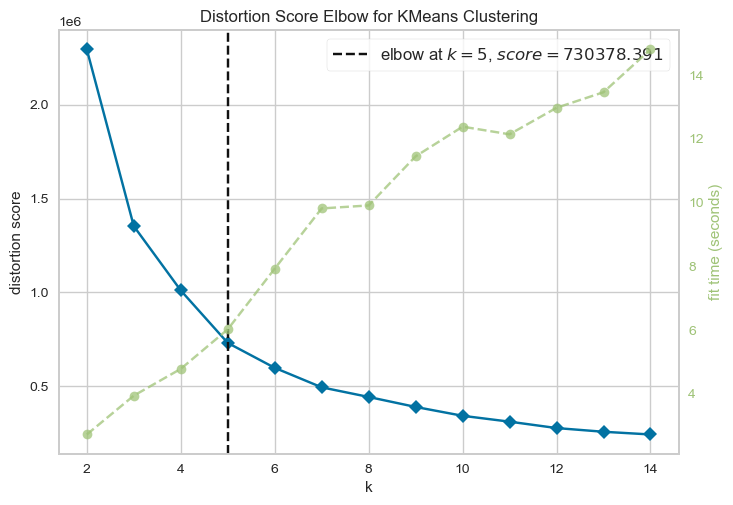

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=14, random_state=0), k=(2, 15))

In [ ]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=0), df_scaled, k=(2,15))

In [ ]:
# 클러스터링
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(df_scaled)

# 클러스터링 변수 
df_cluster['cluster'] = clusters.labels_
df_cluster.head(5)

,purchase_score,action_score,cluster
0,10,14,4
1,10,10,4
2,10,10,4
3,10,10,4
4,10,10,4


In [ ]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled['cluster'] = kmeans.labels_
df_scaled.columns = ['purchase_score', 'action_score', 'cluster']
df_scaled

,purchase_score,action_score,cluster
0,-1.0723,-0.0476,4
1,-1.0723,-0.8596,4
2,-1.0723,-0.8596,4
3,-1.0723,-0.8596,4
4,-1.0723,-0.8596,4
...,...,...,...
1878783,-1.0723,-0.0476,4
1878784,-1.0723,-0.4536,4
1878785,-1.0723,-0.8596,4
1878786,-0.0087,-0.8596,0


In [ ]:
center = kmeans.cluster_centers_
center

center = pd.DataFrame(center)
center['cluster'] = [0,1,2,3,4]
center.columns = ['purchase_score', 'action_score', 'cluster']
center

dd = df_cluster.groupby('cluster',as_index=False).agg({'purchase_score': 'count'})
dd.rename(columns = {'purchase_score' : 'count'}, inplace = True)
center = pd.merge(center, dd, on = 'cluster', how = 'left')
center

,purchase_score,action_score,cluster,count
0,0.2227,-0.5075,0,539102
1,-0.8016,0.8626,1,325217
2,1.0055,2.7499,2,113305
3,1.3802,-0.0539,3,391696
4,-1.0087,-0.5838,4,509468


In [ ]:
total['cluster'] = kmeans.labels_
total

,고유번호,purchase_score,action_score,cluster
0,48066EF2E782C577A25A7A0C38CFCAECE33A2420BFB8EC...,10,14,4
1,4ED3B18A3DB2CE13DE559397E59FAF3701B9A49685EB28...,10,10,4
2,47EB4685B42EF7BD6B60DCBAF4611FC729D1FA3189D149...,10,10,4
3,F017BC3BC9940394BD291128D6C21E6F33B0FB69A63C71...,10,10,4
4,ACF7ECFA0C20E47E546A0A17A1F992635DBF9BD10BD386...,10,10,4
...,...,...,...,...
1878783,A1F7001C515A5EE424CAD2E96AC61D8E5033D272EB9223...,10,14,4
1878784,48BDB945E8C6164F560C662E7044B534AFF4CA1594FCEC...,10,12,4
1878785,D8282C22F8CDCA27671045DC5BDEBF9555A1538AD2FCF3...,10,10,4
1878786,55A29120C4A4E1F9D770B0DE07B82376495121CC0420B0...,24,10,0


In [ ]:
zz = total.groupby('cluster', as_index = False).agg({'purchase_score' : 'mean', 'action_score': 'mean'})
xx = total.groupby('cluster', as_index = False).agg({'purchase_score' : 'count'})
xx.columns = ['cluster', 'count']
cc = pd.merge(zz, xx, on = 'cluster', how = 'left')

In [ ]:
#cc.to_csv('../DATA_raw2/cluster요약.csv', index=False)

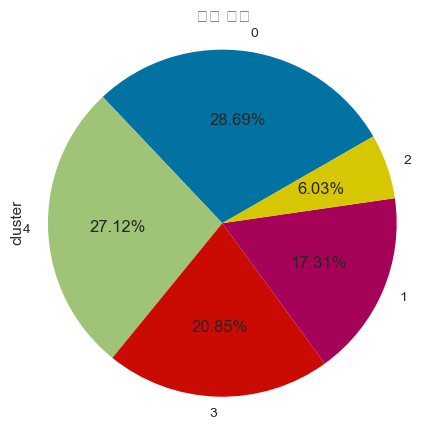

In [ ]:
plt.figure(figsize=(3,3))
total.cluster.value_counts().plot.pie(autopct='%.2f%%', figsize=(5,5), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal') # 안하면 찌그러짐.
plt.show()

In [ ]:
# cluster를 기준으로 데이터 개수
df_cluster.groupby('cluster').count()

,purchase_score,action_score
cluster,,
0,539102,539102
1,325217,325217
2,113305,113305
3,391696,391696
4,509468,509468


In [ ]:
# 그룹별 평균값
df_cluster.groupby('cluster').mean()

,purchase_score,action_score
cluster,,
0,27.0461,11.7349
1,13.5624,18.4837
2,37.3501,27.7804
3,42.2817,13.9690
4,10.8368,11.3589


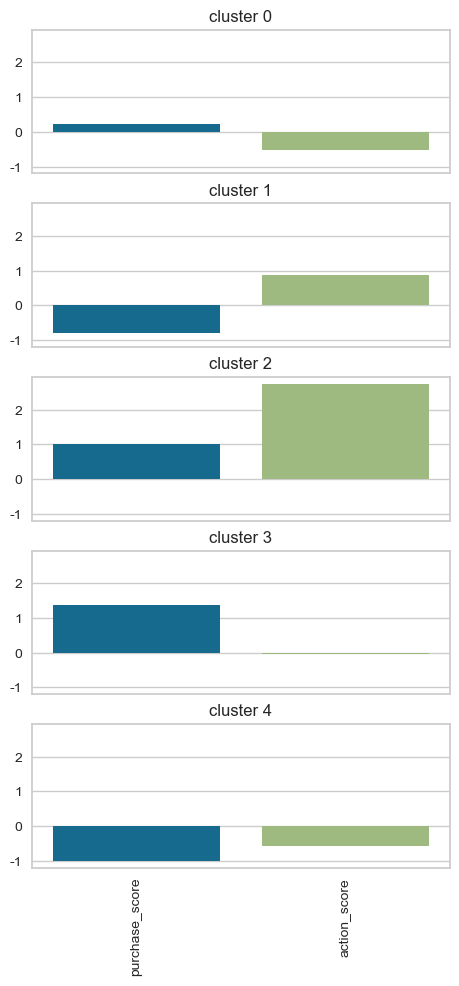

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(5, 1, figsize=(5,9), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정
#plt.subplots_adjust(hspace=0.2) # subplot간의 너비 간격 조절

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(df_cluster.iloc[:,:2].columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(df_cluster.iloc[:,:2].columns.size))
    ax[i].set_xticklabels(df_cluster.iloc[:,:2].columns, rotation=90)
# 군집별로 의미있는 해석 도출해내기

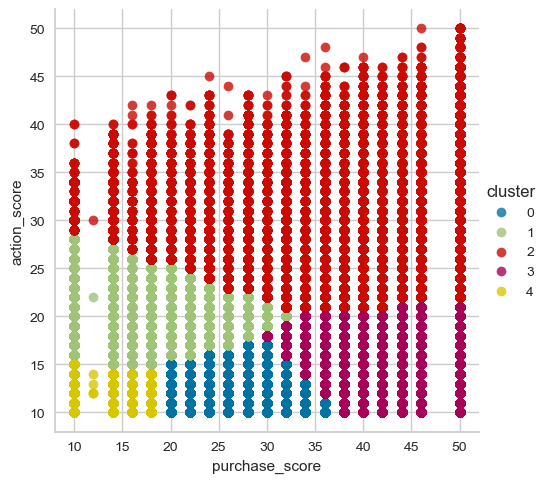

In [ ]:
sns.lmplot(x='purchase_score', y='action_score', data = total, hue = 'cluster', fit_reg=False)

In [ ]:
qq = df_cluster.groupby('cluster', as_index=False).agg({'purchase_score' : 'count'}).sort_values(by=['purchase_score'], ascending = False)
qq['ratio'] = qq['purchase_score'] / qq['purchase_score'].sum() * 100
qq  # 6%

,cluster,purchase_score,ratio
0,0,539102,28.6941
4,4,509468,27.1168
3,3,391696,20.8483
1,1,325217,17.3099
2,2,113305,6.0307


![KakaoTalk_Photo_2023-03-10-12-30-25%20001.png](attachment:KakaoTalk_Photo_2023-03-10-12-30-25%20001.png)

In [ ]:
#plt.figure(figsize=(6,6))
#ax = sns.scatterplot(x='purchase_score', y='action_score', data = total, hue = 'cluster', size = 'cluster_size')
#sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
#plt.show()

In [ ]:
#plt.figure(figsize=(6,6))
#plt.scatter(df_scaled['purchase_score'], df_scaled['action_score'], c = df_scaled['cluster'], cmap = 'YlOrBr')
#plt.scatter(center[:,0], center[:,1], c='red', marker = 's')


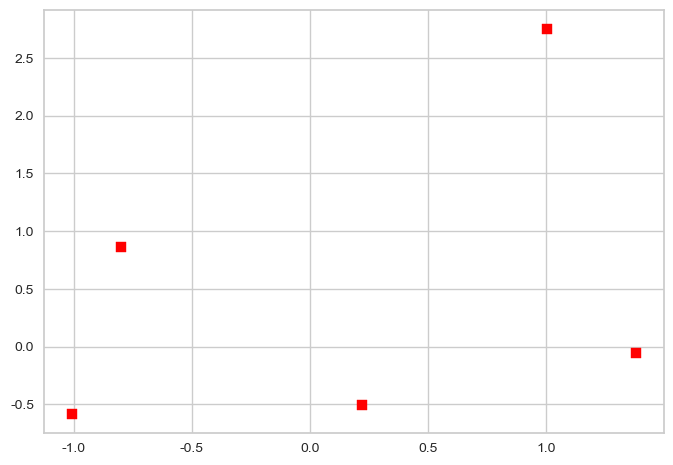

In [ ]:
center = kmeans.cluster_centers_
center
plt.scatter(center[:,0], center[:,1], c='red', marker = 's')

# k-Means : 수동으로 k=7 (상위 = 2.5% 일치)

In [ ]:
total = pd.merge(purchase[['고유번호','purchase_score' ]], action[['고유번호', 'action_score']],on='고유번호',how = 'left')
df_cluster = total.drop(labels='고유번호',axis=1)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#표준화
sc = StandardScaler()
df_scaled = sc.fit_transform(df_cluster)

In [ ]:
# 클러스터링
kmeans = KMeans(n_clusters=7, random_state=0)
clusters = kmeans.fit(df_scaled)

# 클러스터링 변수 
df_cluster['cluster'] = clusters.labels_

df_scaled = pd.DataFrame(df_scaled)
df_scaled['cluster'] = kmeans.labels_
df_scaled.columns = ['purchase_score', 'action_score', 'cluster']
center = kmeans.cluster_centers_

total['cluster'] = kmeans.labels_

In [ ]:
pd.set_option('display.max_columns',None) # 전체 열 출력하기
pd.set_option('display.max_rows',None) # 전체 행 출력하기

In [ ]:
aa = user_fin[user_fin.고유번호.isin(total[total.cluster == 6].고유번호.unique())]
aa[[ '구매횟수', '연 평균 구매횟수', '구매상품수',
       '연 평균 구매상품수', '결제가 총합', '연 평균 결제가 총합', '쿠폰사용횟수', '연 평균 쿠폰사용횟수',
       '포인트사용횟수', '연 평균 포인트사용횟수', 'c_출석체크_참여일수(누적)',
       '연 평균 출첵참여횟수', 'c_일반이벤트_응모건수(누적)','연 평균 일반이벤트횟수','c_드로우 응모건수(누적)', '연 평균 드로우횟수', 
       '리뷰작성건수','연 평균 리뷰작성횟수']].describe()

In [ ]:
aa = user_fin[user_fin.고유번호.isin(total[total.cluster == 5].고유번호.unique())]
aa[[ '구매횟수', '연 평균 구매횟수', '구매상품수',
       '연 평균 구매상품수', '결제가 총합', '연 평균 결제가 총합', '쿠폰사용횟수', '연 평균 쿠폰사용횟수',
       '포인트사용횟수', '연 평균 포인트사용횟수', 'c_출석체크_참여일수(누적)',
       '연 평균 출첵참여횟수', 'c_일반이벤트_응모건수(누적)','연 평균 일반이벤트횟수','c_드로우 응모건수(누적)', '연 평균 드로우횟수', 
       '리뷰작성건수','연 평균 리뷰작성횟수']].describe()

In [ ]:
aa = user_fin[user_fin.고유번호.isin(total[total.cluster == 5].고유번호.unique())]
aa[[ '구매횟수', '연 평균 구매횟수', '구매상품수',
       '연 평균 구매상품수', '결제가 총합', '연 평균 결제가 총합', '쿠폰사용횟수', '연 평균 쿠폰사용횟수',
       '포인트사용횟수', '연 평균 포인트사용횟수', 'c_출석체크_참여일수(누적)',
       '연 평균 출첵참여횟수', 'c_일반이벤트_응모건수(누적)','연 평균 일반이벤트횟수','c_드로우 응모건수(누적)', '연 평균 드로우횟수', 
       '리뷰작성건수','연 평균 리뷰작성횟수']].describe()

In [ ]:
aa = user_fin[user_fin.고유번호.isin(total[total.cluster == 6].고유번호.unique())]
aa[['연 평균 구매횟수','연 평균 구매상품수', '연 평균 결제가 총합', '연 평균 쿠폰사용횟수','연 평균 포인트사용횟수','연 평균 출첵참여횟수','연 평균 일반이벤트횟수','연 평균 드로우횟수',
'연 평균 리뷰작성횟수']].describe()

In [ ]:
zz = total.groupby('cluster', as_index = False).agg({'purchase_score' : 'mean', 'action_score': 'mean'})
xx = total.groupby('cluster', as_index = False).agg({'purchase_score' : 'count'})
xx.columns = ['cluster', 'count']
cc = pd.merge(zz, xx, on = 'cluster', how = 'left')

In [ ]:
cc

,cluster,purchase_score,action_score,count
0,0,26.5081,11.7527,506992
1,1,42.1024,12.5649,330733
2,2,11.9162,16.3010,355017
3,3,16.5903,24.3406,86493
4,4,10.8318,10.6515,401032
5,5,42.1338,31.5811,51215
6,6,39.2014,19.3353,147306


In [ ]:
cc.to_csv('../DATA_raw2/cluster요약3.csv', index=False)

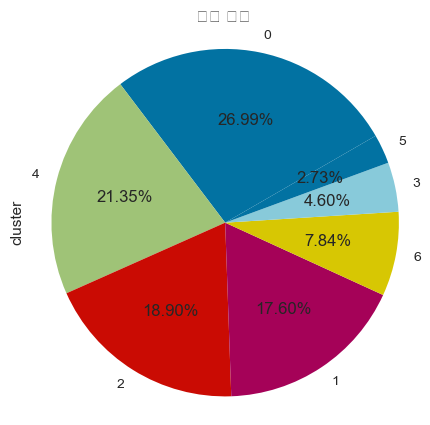

In [ ]:
plt.figure(figsize=(3,3))
total.cluster.value_counts().plot.pie(autopct='%.2f%%', figsize=(5,5), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal') # 안하면 찌그러짐.
plt.show()

In [ ]:
# cluster를 기준으로 데이터 개수
df_cluster.groupby('cluster').count()

,purchase_score,action_score
cluster,,
0,506992,506992
1,330733,330733
2,355017,355017
3,86493,86493
4,401032,401032
5,51215,51215
6,147306,147306


In [ ]:
# 그룹별 평균값
df_cluster.groupby('cluster').mean()

,purchase_score,action_score
cluster,,
0,26.5081,11.7527
1,42.1024,12.5649
2,11.9162,16.3010
3,16.5903,24.3406
4,10.8318,10.6515
5,42.1338,31.5811
6,39.2014,19.3353


In [ ]:
qq = df_cluster.groupby('cluster', as_index=False).agg({'purchase_score' : 'count'}).sort_values(by=['purchase_score'], ascending = False)
qq['ratio'] = qq['purchase_score'] / qq['purchase_score'].sum() * 100
qq  #  4%

,cluster,purchase_score,ratio
0,0,506992,26.9851
4,4,401032,21.3453
2,2,355017,18.8961
1,1,330733,17.6035
6,6,147306,7.8405
3,3,86493,4.6037
5,5,51215,2.7260


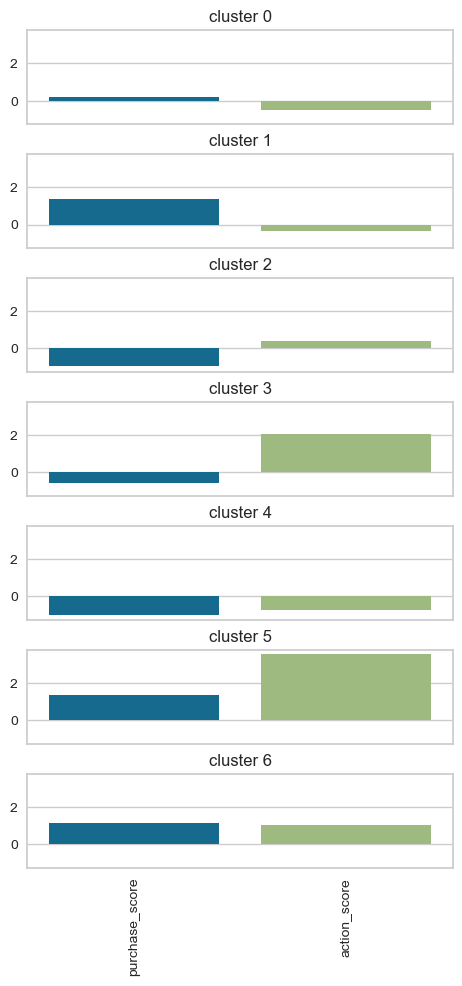

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(7, 1, figsize=(5,9), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정
#plt.subplots_adjust(hspace=0.2) # subplot간의 너비 간격 조절

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(df_cluster.iloc[:,:2].columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(df_cluster.iloc[:,:2].columns.size))
    ax[i].set_xticklabels(df_cluster.iloc[:,:2].columns, rotation=90)
# 군집별로 의미있는 해석 도출해내기

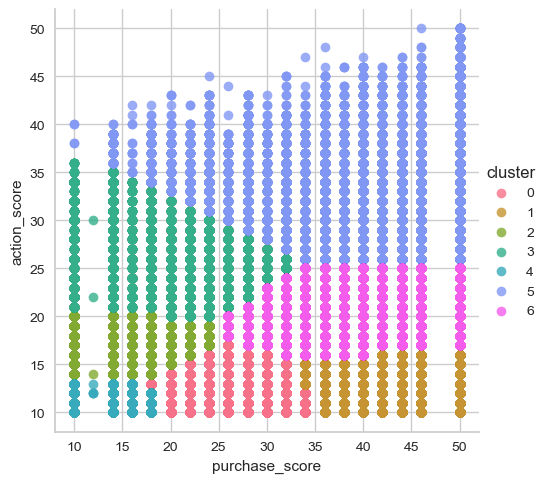

In [ ]:
sns.lmplot(x='purchase_score', y='action_score', data = total, hue = 'cluster', fit_reg=False)

![KakaoTalk_Photo_2023-03-10-16-10-49.png](attachment:KakaoTalk_Photo_2023-03-10-16-10-49.png)

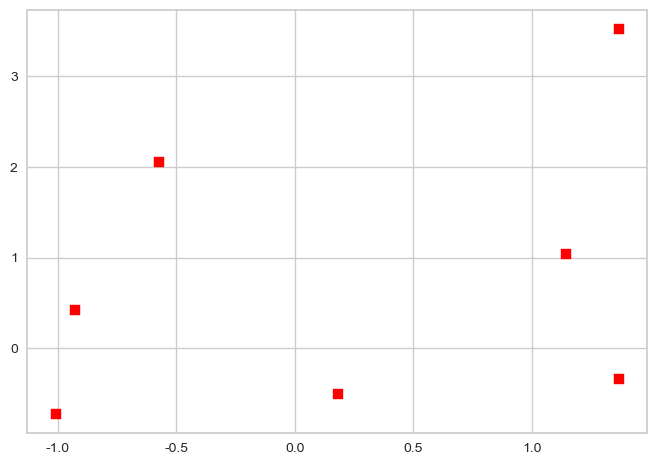

In [ ]:
center = kmeans.cluster_centers_
center
plt.scatter(center[:,0], center[:,1], c='red', marker = 's')